# Step 3.2: Check Client Requirements

In this step of the project we establish the necessary functions to validate Client Requirements

In [42]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer, BoolTransformer

import json
import joblib
import pickle
import requests
from time import sleep
import random

import warnings
warnings.filterwarnings("error")

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 


# Requirement Validation Functions

In [43]:
def verify_success_rate(y_true, y_pred, min_success_rate=0.8):
    """
    Verifies the success rate on a test set is above a provided minimum
    
    We shall consider success for this project as the model having at least 0.8 recall
    
    """
    
    recall = recall_score(y_true, y_pred, pos_label=True)
    is_satisfied = (recall >= min_success_rate)

    return is_satisfied, recall

In [44]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='Officer-defined ethnicity', max_diff=0.05, min_samples=50):
    """
    Verifies that no subdeparment has discrimination in between protected races
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if np.sum(y_true[mask]) > min_samples:   # the department needs to have at least some positive labels so that precision makes sense
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0) # defaults to 0 if the model predicted 0 success outcomes
                
        if len(precisions) > 1:    
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(y_true[mask]) > min_samples: # the department needs to have at least some positive labels so that precision makes sense
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0) # defaults to 0 if the model predicted 0 success outcomes
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, global_precisions


# Get the data

In [45]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Retrain Baseline Model

In [46]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()

    # Encode Target data
    # lb = LabelEncoder()
    # lb.fit(y)
    # y_bin = pd.DataFrame(data= lb.transform(y), columns= ['readmitted'])

    # categorical_cols = list(X.select_dtypes(include=['object']).columns)
    # numerical_cols = list(X.select_dtypes(include=['number']).columns)
    time_cols = ['Date']

    categorical_cols = ['Type', 'Gender', 'Age range', 'Officer-defined ethnicity', 'Legislation', 'Object of search', 'station']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude']

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer())
        ])

    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            # ('imputer', SimpleImputer(strategy='constant', fill_value=False)),
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', SimpleImputer()),
            ('scaler', StandardScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
 

    pipeline.fit(X, np.ravel(y))
    # pipeline.fit(X, np.ravel(y_bin))


    return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    roc_aucs = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(roc_aucs)

In [47]:
model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.23809524 0.26742712 0.23410088 0.22156013 0.24725944]


# Predict

In [48]:
# use the pipeline and get predictions and probas

# TRAIN SET

y_train = df_train["target"].copy()
X_train = df_train.drop(columns=["target"]).copy()


# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

In [49]:
verify_success_rate(y_test, y_pred_test, min_success_rate=0.1)

(False, 0.042683797287651676)

In [50]:
is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Officer-defined ethnicity', max_diff=0.05, min_samples=5)

print("Race")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Race
Requirement failed
Global rates: {'White': 0.2512, 'Black': 0.22831858407079647, 'Asian': 0.19429590017825313, 'Mixed': 0.2459016393442623, 'Other': 0.2318840579710145}
Num problematic departments: 20
Num good departments: 13
avg diff: 0.31372071986390465


In [51]:
is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Gender', max_diff=0.05, min_samples=5)

print("Gender")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Gender
Requirement failed
Global rates: {'Male': 0.24008632317237658, 'Female': 0.14285714285714285, 'Other': 0.0}
Num problematic departments: 20
Num good departments: 15
avg diff: 0.24576519416232614


In [52]:
is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Age range', max_diff=0.05, min_samples=5)

print("Age")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Age
Requirement failed
Global rates: {'25-34': 0.2616651418115279, '10-17': 0.17701149425287357, '18-24': 0.24517906336088155, 'over 34': 0.2296774193548387, 'under 10': 0.0}
Num problematic departments: 20
Num good departments: 17
avg diff: 0.29815487233829974


## Requirement Valation Functions - Discrimination Function v2

During the Comments Phase for Part 1 of the Project we noticed that the Discrimination Validation function was not correct. We needed a function that validated discrimination for each station and for each race-gender tuple. No valition was necessary for Age Range.

In [53]:
def verify_no_discrimination_v2(X_test, y_true, y_pred, max_diff=0.05, min_samples=5):
    """
    Verifies that no subdeparment has discrimination in between protected races
    """
    
    departments = X_test['station'].unique()
    ethnicity_classes = X_test['Officer-defined ethnicity'].unique()
    gender_classes = X_test['Gender'].unique()
    
    sensitive_classes = [(x,y) for x in ethnicity_classes for y in gender_classes]

    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    all_departments = {}
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:

            mask = (X_test['Officer-defined ethnicity'] == sensitive_class[0]) & (X_test['Gender'] == sensitive_class[1]) & (X_test['station'] == department)
            if np.sum(y_true[mask]) > min_samples:   # the department needs to have at least some positive labels so that it makes sense to measure the precision
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0) # defaults to 0 if the model predicted 0 success outcomes
                
        if len(precisions) > 1:

            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            print(department + "was ignored")
            ignored_departments.append((department, None, []))
        
        all_departments[department] = precisions
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test['Officer-defined ethnicity'] == sensitive_class[0]) & (X_test['Gender'] == sensitive_class[1])
        if np.sum(y_true[mask]) > min_samples: # the department needs to have at least some positive labels so that precision makes sense
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0) # defaults to 0 if the model predicted 0 success outcomes
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments

In [54]:
is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = verify_no_discrimination_v2(X_test, y_test, y_pred_test, max_diff=0.05, min_samples=1)

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Requirement failed
Global rates: {('White', 'Male'): 0.2528455284552846, ('White', 'Female'): 0.15, ('White', 'Other'): 0.0, ('Black', 'Male'): 0.22953736654804271, ('Black', 'Female'): 0.0, ('Asian', 'Male'): 0.19569120287253142, ('Asian', 'Female'): 0.0, ('Mixed', 'Male'): 0.2459016393442623, ('Mixed', 'Female'): 0.0, ('Other', 'Male'): 0.22388059701492538, ('Other', 'Female'): 0.5}
Num problematic departments: 21
Num good departments: 16
avg diff: 0.3903633461067243


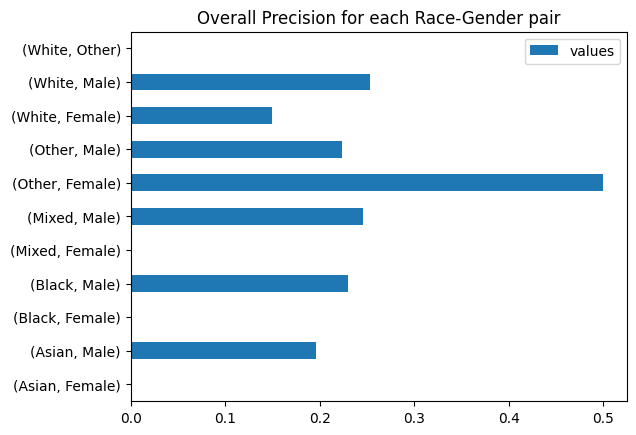

In [55]:
pd.DataFrame(global_precisions, index=["values"]).transpose().sort_index().plot.barh()
plt.title("Overall Precision for each Race-Gender pair");

In [56]:
pd.DataFrame(all_departments).sort_index().transpose()

Asian            Black            Mixed            Other  \
                   Female      Male Female      Male Female      Male Female   
south-yorkshire       0.0  0.368421    0.0  0.153846    NaN       NaN    0.0   
hampshire             0.0  0.000000    0.0  0.000000    NaN       NaN    0.0   
devon-and-cornwall    NaN  0.000000    NaN  0.416667    NaN       NaN    NaN   
north-wales           NaN  0.000000    NaN  0.000000    NaN       NaN    0.0   
sussex                NaN  0.000000    0.0  0.000000    NaN       NaN    NaN   
suffolk               NaN  0.000000    0.0  0.500000    NaN  0.000000    NaN   
merseyside            NaN  0.000000    0.0  0.000000    NaN       NaN    NaN   
thames-valley         0.0  0.123077    0.0  0.140187    NaN       NaN    NaN   
kent                  0.0  0.000000    0.0  0.176471    NaN  0.500000    0.0   
surrey                NaN  0.227273    0.0  0.162162    NaN  0.000000    0.0   
west-yorkshire        0.0  0.169118    0.0  0.206522    NaN       NaN    NaN   
norfolk               NaN  0.000000    NaN  0.000000    NaN  0.000000    NaN   
northumbria           0.0  0.000000    NaN  0.000000    NaN  0.000000    0.0   
west-mercia           NaN  0.500000    0.0  0.571429    0.0  0.000000    NaN   
hertfordshire         0.0  0.083333    0.0  0.083333    NaN       NaN    NaN   
staffordshire         0.0  0.000000    0.0  0.000000    NaN       NaN    NaN   
essex                 0.0  0.482759    0.0  0.337838    NaN       NaN    0.5   
cleveland             NaN  0.000000    NaN       NaN    NaN       NaN    NaN   
avon-and-somerset     NaN  0.000000    0.0  0.000000    0.0  0.000000    NaN   
dorset                NaN  0.000000    NaN  0.000000    NaN       NaN    NaN   
nottinghamshire       NaN  0.225352    NaN  0.287037    0.0  0.234043    NaN   
btp                   0.0  0.000000    0.0  0.000000    NaN       NaN    0.0   
cambridgeshire        NaN  0.333333    0.0  0.333333    NaN       NaN    NaN   
cumbria               NaN  0.000000    NaN  0.000000    NaN       NaN    NaN   
west-midlands         NaN  0.000000    NaN  0.000000    NaN       NaN    NaN   
gloucestershire       NaN  0.000000    NaN  0.000000    NaN       NaN    NaN   
bedfordshire          0.0  0.068966    NaN  0.217391    NaN       NaN    NaN   
dyfed-powys           NaN       NaN    NaN  0.000000    NaN       NaN    NaN   
wiltshire             NaN  0.000000    NaN  0.000000    NaN       NaN    NaN   
northamptonshire      NaN  1.000000    0.0  0.100000    NaN       NaN    NaN   
cheshire              NaN  0.000000    NaN  0.000000    NaN       NaN    NaN   
lincolnshire          NaN  0.000000    NaN  0.000000    NaN       NaN    NaN   
warwickshire          NaN  0.300000    NaN  0.411765    0.0  0.000000    NaN   
city-of-london        0.0  0.000000    0.0  0.000000    NaN       NaN    NaN   
derbyshire            NaN  0.000000    NaN  0.000000    NaN       NaN    NaN   
north-yorkshire       NaN  0.000000    NaN  0.000000    NaN       NaN    NaN   
durham                NaN  0.000000    NaN       NaN    NaN       NaN    NaN   

                                 White                  
                        Male    Female      Male Other  
south-yorkshire     0.000000  0.000000  0.174312   NaN  
hampshire           0.000000  0.000000  0.000000   0.0  
devon-and-cornwall  0.000000  0.000000  0.238636   NaN  
north-wales         0.000000  0.000000  0.000000   NaN  
sussex              0.000000  0.000000  0.291667   NaN  
suffolk             0.000000  0.000000  0.062500   NaN  
merseyside          0.000000  0.000000  0.000000   NaN  
thames-valley       0.000000  0.250000  0.200000   NaN  
kent                0.142857  0.000000  0.184211   NaN  
surrey              0.000000  0.000000  0.119403   NaN  
west-yorkshire      0.100000  0.000000  0.191919   NaN  
norfolk             0.000000  0.000000  0.187500   NaN  
northumbria         0.000000  0.000000  0.000000   NaN  
west-mercia         0.000000  1.000000  0.12

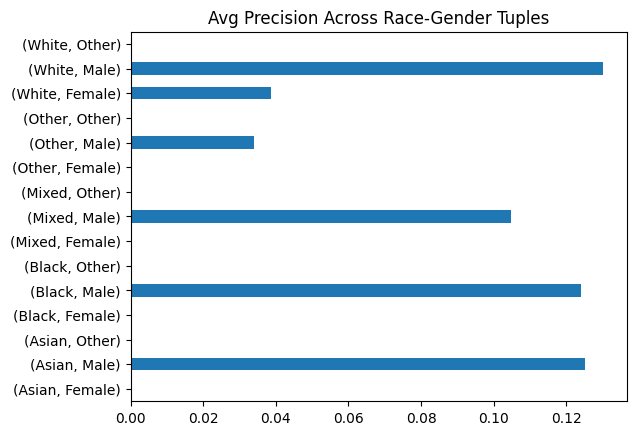

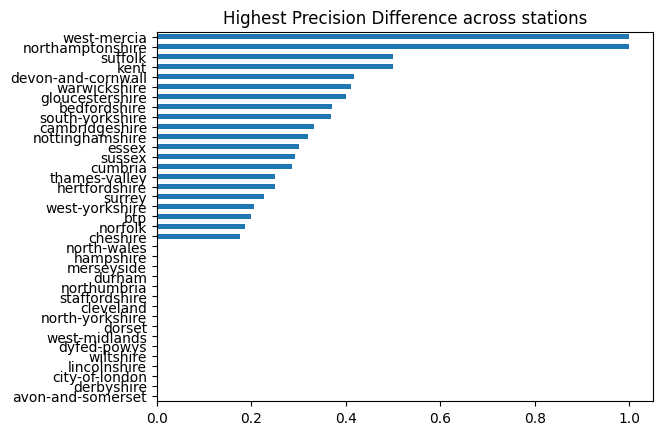

Requirement failed
Global rates: {('White', 'Male'): 0.13015562839654435, ('White', 'Female'): 0.0386977886977887, ('White', 'Other'): 0.0, ('Black', 'Male'): 0.12418122270087438, ('Black', 'Female'): 0.0, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.12521391184883257, ('Asian', 'Female'): 0.0, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.10486322188449848, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.03383458646616542, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 21
Num good departments: 16
avg diff: 0.21617729729729732


In [57]:
def verify_no_discrimination_v3(X_test, y_true, y_pred, max_diff=0.05, min_samples=30):  

    departments = X_test['station'].unique()
    ethnicity_classes = X_test['Officer-defined ethnicity'].unique()
    gender_classes = X_test['Gender'].unique()

    sensitive_classes = [(x,y) for x in ethnicity_classes for y in gender_classes]

    department_rates = {}
    for department in departments:
        precision_rates = {}
        for sensitive_class in sensitive_classes:

            mask = (X_test['Officer-defined ethnicity'] == sensitive_class[0]) & (X_test['Gender'] == sensitive_class[1]) & (X_test['station'] == department)
            
            total = len(X_test[mask])

            # client suggests checking discrimination only for race-gender tuples that have a minimum of 30 samples
            if(total < min_samples):
                precision_rate = np.nan 
            else:
                precision_rate = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)

            precision_rates[sensitive_class] = precision_rate
        department_rates[department] = precision_rates

    rates = pd.DataFrame.from_dict(department_rates).transpose()

    global_precisions = rates.transpose().mean(axis=1).to_dict()

    rates.transpose().mean(axis=1).sort_index().plot.barh()
    plt.title("Avg Precision Across Race-Gender Tuples")
    plt.show();
    
    rates["diff"] = rates.max(axis=1).round(5) - rates.min(axis=1).round(5)

    good_deparments = list(rates.loc[rates["diff"]<max_diff].index)

    problematic_departments = list(rates.loc[rates["diff"]>=max_diff].index)

    if len(problematic_departments) > 0:
        is_satisfied = False
    else:
        is_satisfied = True

    all_departments = rates.copy()

    rates["diff"].sort_values().plot.barh()
    plt.title("Highest Precision Difference across stations")
    plt.show();

    # pd.DataFrame(global_precisions, index=["avg difference"]).plot.barh()
    # plt.title("Difference across stations")


    return is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments
    

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = verify_no_discrimination_v3(X_test, y_test, y_pred_test)

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")


In [58]:

all_departments.drop().transpose()

ValueError: Need to specify at least one of 'labels', 'index' or 'columns'

In [ ]:

all_departments.transpose().mean(axis=1).to_dict()

{('White', 'Male'): 0.13015562839654435,
 ('White', 'Female'): 0.0386977886977887,
 ('White', 'Other'): 0.0,
 ('Black', 'Male'): 0.12418122270087438,
 ('Black', 'Female'): 0.0,
 ('Black', 'Other'): nan,
 ('Asian', 'Male'): 0.12521391184883257,
 ('Asian', 'Female'): 0.0,
 ('Asian', 'Other'): nan,
 ('Mixed', 'Male'): 0.10486322188449848,
 ('Mixed', 'Female'): nan,
 ('Mixed', 'Other'): nan,
 ('Other', 'Male'): 0.03383458646616542,
 ('Other', 'Female'): nan,
 ('Other', 'Other'): nan,
 ('diff', ''): 0.21617729729729732}